# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [41]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [42]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [43]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-08 09:00:00+09:00,47925.218750,48012.320312,47845.628906,47899.671875,0,0.0,0.0
2025-10-08 09:15:00+09:00,47885.351562,48091.539062,47880.039062,48016.878906,0,0.0,0.0
2025-10-08 09:30:00+09:00,48028.101562,48139.890625,47976.640625,48126.929688,0,0.0,0.0
2025-10-08 09:45:00+09:00,48124.648438,48181.121094,48049.570312,48062.750000,0,0.0,0.0
2025-10-08 10:00:00+09:00,48063.531250,48096.550781,48037.250000,48054.421875,0,0.0,0.0
2025-10-08 10:15:00+09:00,48054.820312,48087.480469,48017.050781,48027.261719,0,0.0,0.0
2025-10-08 10:30:00+09:00,48029.109375,48063.308594,47918.289062,47953.820312,0,0.0,0.0
2025-10-08 10:45:00+09:00,47961.761719,48011.199219,47904.218750,47914.308594,0,0.0,0.0
2025-10-08 11:00:00+09:00,47916.390625,48012.750000,47892.140625,48008.531250,0,0.0,0.0


## 前日終値の取得

In [44]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-01 00:00:00+09:00    44550.851562
2025-10-02 00:00:00+09:00    44936.730469
2025-10-03 00:00:00+09:00    45769.500000
2025-10-06 00:00:00+09:00    47944.761719
2025-10-07 00:00:00+09:00    47950.878906
2025-10-08 00:00:00+09:00    47734.988281
Name: Close, dtype: float64


Date
2025-10-07 00:00:00+09:00    47950.878906
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [45]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-25.66


## ローソク足チャート（小さいサイズ）

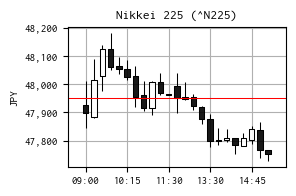

In [46]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

In [47]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

In [48]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-07 08:00:00+09:00,150.313004,150.371002,150.255997,150.367004,0,0.0,0.0
2025-10-07 08:15:00+09:00,150.362000,150.391998,150.347000,150.373001,0,0.0,0.0
2025-10-07 08:30:00+09:00,150.369995,150.395004,150.279999,150.317993,0,0.0,0.0
2025-10-07 08:45:00+09:00,150.311996,150.369995,150.287003,150.360001,0,0.0,0.0
2025-10-07 09:00:00+09:00,150.358994,150.582001,150.354004,150.567001,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-08 15:30:00+09:00,152.466003,152.513000,152.367004,152.432999,0,0.0,0.0
2025-10-08 15:45:00+09:00,152.436005,152.438995,152.324997,152.339005,0,0.0,0.0
2025-10-08 16:00:00+09:00,152.339005,152.453995,152.324997,152.442993,0,0.0,0.0


In [49]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-08 09:00:00+09:00,314.757018,315.329072,314.234298,314.589234
2025-10-08 09:15:00+09:00,314.408472,315.762270,314.373591,315.272062
2025-10-08 09:30:00+09:00,315.434804,316.169003,315.096824,316.083879
2025-10-08 09:45:00+09:00,315.975515,316.346301,315.482569,315.569104
2025-10-08 10:00:00+09:00,315.565918,315.782711,315.393366,315.506110
2025-10-08 10:15:00+09:00,315.183839,315.398052,314.936115,315.003087
2025-10-08 10:30:00+09:00,315.112338,315.336714,314.385261,314.618376
2025-10-08 10:45:00+09:00,314.305512,314.629488,313.928418,313.994540
2025-10-08 11:00:00+09:00,314.067853,314.699441,313.908907,314.671789


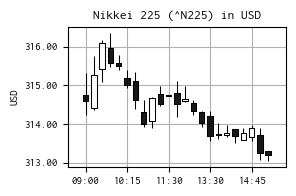

In [50]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
# ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()